Shaked Tayouri ‚Äì 323866749

Noa Magrisso ‚Äì 206934978

# Load Data and Liberies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import os
import glob as glob
import cv2
import requests
import random

np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels_data = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/ML Task 4/imagelabels.mat')
labels = labels_data['labels'].flatten() # Extract the labels from the loaded data

print(np.unique(labels))

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


## Data imbalance

In [ ]:
import numpy as np
from collections import Counter

class_distribution = Counter(labels)
print("Class distribution in training set:", class_distribution)

Class distribution in training set: Counter({np.uint8(51): 258, np.uint8(77): 251, np.uint8(46): 196, np.uint8(73): 194, np.uint8(89): 184, np.uint8(74): 171, np.uint8(81): 166, np.uint8(94): 162, np.uint8(88): 154, np.uint8(78): 137, np.uint8(83): 131, np.uint8(43): 130, np.uint8(95): 128, np.uint8(41): 127, np.uint8(75): 120, np.uint8(58): 114, np.uint8(82): 112, np.uint8(56): 109, np.uint8(60): 109, np.uint8(37): 108, np.uint8(76): 107, np.uint8(80): 105, np.uint8(65): 102, np.uint8(72): 96, np.uint8(44): 93, np.uint8(53): 93, np.uint8(50): 92, np.uint8(23): 91, np.uint8(96): 91, np.uint8(11): 87, np.uint8(12): 87, np.uint8(84): 86, np.uint8(8): 85, np.uint8(30): 85, np.uint8(17): 85, np.uint8(52): 85, np.uint8(18): 82, np.uint8(90): 82, np.uint8(98): 82, np.uint8(29): 78, np.uint8(71): 78, np.uint8(91): 76, np.uint8(36): 75, np.uint8(48): 71, np.uint8(55): 71, np.uint8(40): 67, np.uint8(47): 67, np.uint8(59): 67, np.uint8(57): 67, np.uint8(92): 66, np.uint8(28): 66, np.uint8(97): 6

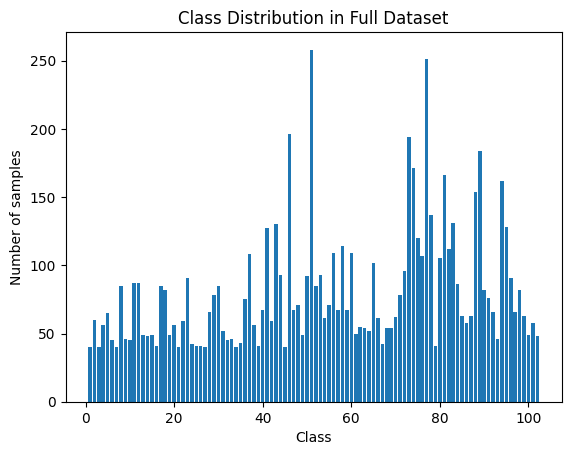

In [ ]:
labels, counts = zip(*class_distribution.items())
plt.bar(labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution in Full Dataset')
plt.show()


## train-test split

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/'

images = filter(lambda photo: photo.startswith('image_') and photo.endswith('.jpg'), os.listdir(dir_path))
sorted_images = sorted(list(images))

print(sorted_images[:10])

['image_00001.jpg', 'image_00002.jpg', 'image_00003.jpg', 'image_00004.jpg', 'image_00005.jpg', 'image_00006.jpg', 'image_00007.jpg', 'image_00008.jpg', 'image_00009.jpg', 'image_00010.jpg']


In [ ]:
full_images = [dir_path + img for img in sorted_images]
print(full_images[:5])

['/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/image_00001.jpg', '/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/image_00002.jpg', '/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/image_00003.jpg', '/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/image_00004.jpg', '/content/drive/MyDrive/Colab Notebooks/ML Task 4/resources/image_00005.jpg']


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training (50%) and temporary set (50%)
X_train, X_temp, y_train, y_temp = train_test_split(full_images, labels, test_size=0.5, random_state=42, stratify=labels)

# Split temporary set into validation (25%) and test (25%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

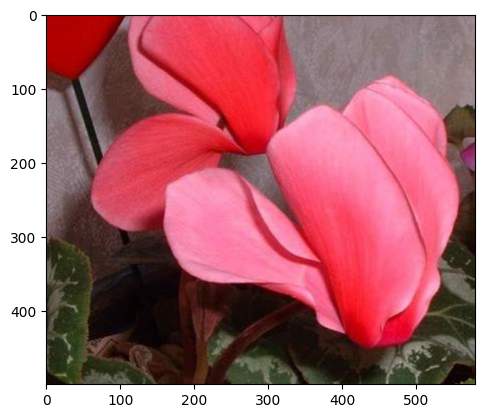

In [ ]:
# Example of image

img = mpimg.imread(X_train[1])
plt.imshow(img)
plt.show()

## Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_images(image_paths, labels, img_height, img_width):
    # Preprocess a batch of images by resizing and normalizing pixel values.
    images = []

    for img_path in image_paths:
        # Load the image and resize it
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)

    # Convert the list of images to a numpy array
    images = np.array(images, dtype=np.float32)

    return images, np.array(labels, dtype=np.float32)

# VGG19

In [ ]:
# VGG16 expects images of size 224x224 pixels

vgg_X_train_preprocessed, vgg_y_train_preprocessed = preprocess_images(X_train, y_train, 224, 224)
vgg_X_val_preprocessed, vgg_y_val_preprocessed = preprocess_images(X_val, y_val, 224, 224)
vgg_X_test_preprocessed, vgg_y_test_preprocessed = preprocess_images(X_test, y_test, 224, 224)

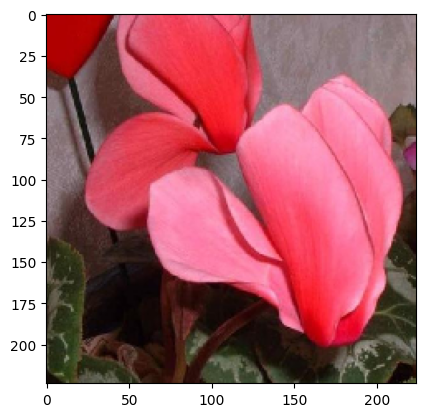

In [ ]:
# Example of normalized image

plt.imshow(vgg_X_train_preprocessed[1])
plt.show()

In [ ]:
!pip install torchvision

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezes all of the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(102, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ vgg19 (Functional)                   ‚îÇ (None, 7, 7, 512)           ‚îÇ      20,024,384 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)                    ‚îÇ (None, 25088)               ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (None, 4096)                ‚îÇ     102,764,544 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (None, 102)                 ‚îÇ         417,894 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 123,206,822 (470.00 MB)

 Trainable params: 103,182,438 (393.61 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_shifted = vgg_y_train_preprocessed - 1
y_val_shifted = vgg_y_val_preprocessed - 1
y_test_shifted = vgg_y_test_preprocessed - 1

# Now convert to categorical
y_train_preprocessed = to_categorical(y_train_shifted)
y_val_preprocessed = to_categorical(y_val_shifted)
y_test_preprocessed = to_categorical(y_test_shifted)

In [ ]:
# Augment training data using ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(vgg_X_train_preprocessed, y_train_preprocessed, batch_size=32)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(vgg_X_val_preprocessed, y_val_preprocessed, batch_size=32)
test_generator = val_datagen.flow(vgg_X_test_preprocessed, y_test_preprocessed, batch_size=32)

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(vgg_X_train_preprocessed) // 32,
    validation_steps=len(vgg_X_val_preprocessed) // 32)

Epoch 1/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 330ms/step - accuracy: 0.0986 - loss: 4.4496 - val_accuracy: 0.3943 - val_loss: 2.5388
Epoch 2/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.4375 - loss: 2.9197 - val_accuracy: 0.3978 - val_loss: 2.5389
Epoch 3/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 315ms/step - accuracy: 0.3988 - loss: 2.5685 - val_accuracy: 0.5198 - val_loss: 1.9687
Epoch 4/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.4062 - loss: 2.3337 - val_accuracy: 0.5129 - val_loss: 1.9984
Epoch 5/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 314ms/step - accuracy: 0.5176 - loss: 2.0076 - val_accuracy: 0.6052 - val_loss: 1.5088
Epoch 6/50
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.6562 - loss: 1.5217 - val_accuracy: 0.6091

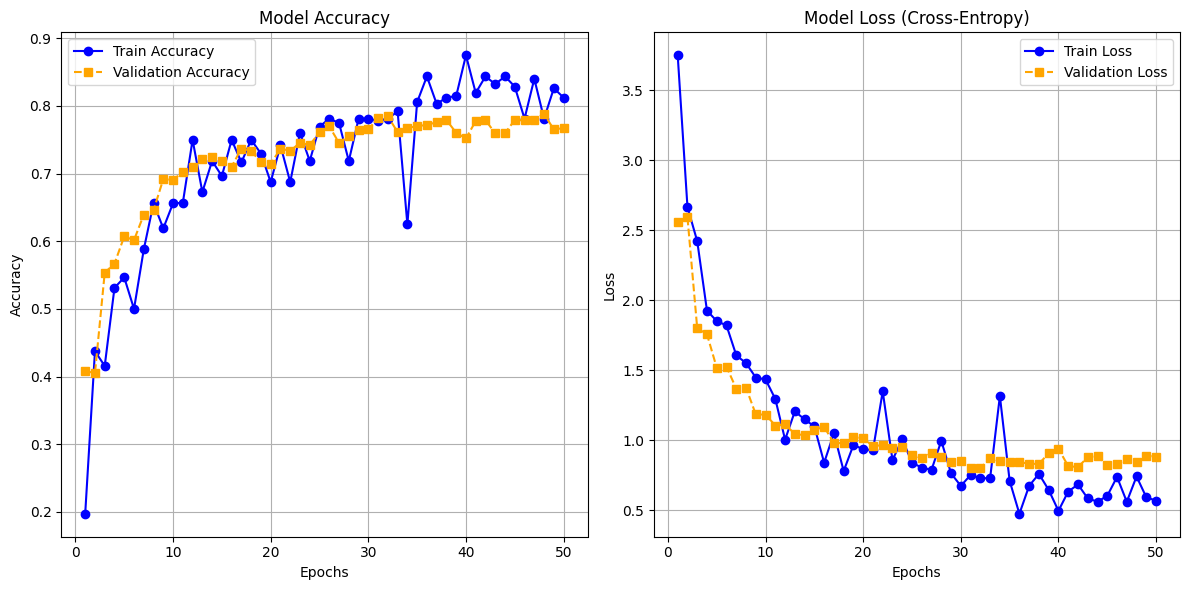

In [ ]:
import matplotlib.pyplot as plt

# Extract history data for plotting
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy Plot
ax1.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o', linestyle='-')
ax1.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='s', linestyle='--')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o', linestyle='-')
ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='s', linestyle='--')
ax2.set_title('Model Loss (Cross-Entropy)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [ ]:
from math import ceil

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=ceil(len(vgg_X_test_preprocessed) / 32))

# Print test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4%}")  # Percentage format

64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 22ms/step - accuracy: 0.7732 - loss: 0.7885
Test Loss: 0.8355
Test Accuracy: 76.7578%


In [ ]:
# Lists to store test results
test_acc_history = []
test_loss_history = []

# Train and evaluate at each epoch
for epoch in range(50):  # 50 epochs
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,  # Train for one epoch at a time
        steps_per_epoch=len(vgg_X_train_preprocessed) // 32,
        validation_steps=len(vgg_X_val_preprocessed) // 32,
        verbose=1
    )

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(vgg_X_test_preprocessed) // 32)

    # Store test accuracy and loss
    test_acc_history.append(test_accuracy)
    test_loss_history.append(test_loss)

127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 313ms/step - accuracy: 0.8529 - loss: 0.5176 - val_accuracy: 0.8001 - val_loss: 0.7594
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 23ms/step - accuracy: 0.7741 - loss: 0.8289
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 314ms/step - accuracy: 0.8582 - loss: 0.4990 - val_accuracy: 0.7832 - val_loss: 0.8051
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.7615 - loss: 0.8720
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 316ms/step - accuracy: 0.8451 - loss: 0.5398 - val_accuracy: 0.7882 - val_loss: 0.7808
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step - accuracy: 0.7820 - loss: 0.8148
127/127 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 313ms/step - accuracy: 0.8743 - loss: 0.4464 - val_accuracy: 0.7837 - val_loss: 0.8017
64/64 ‚îÅ‚îÅ‚îÅ‚îÅ

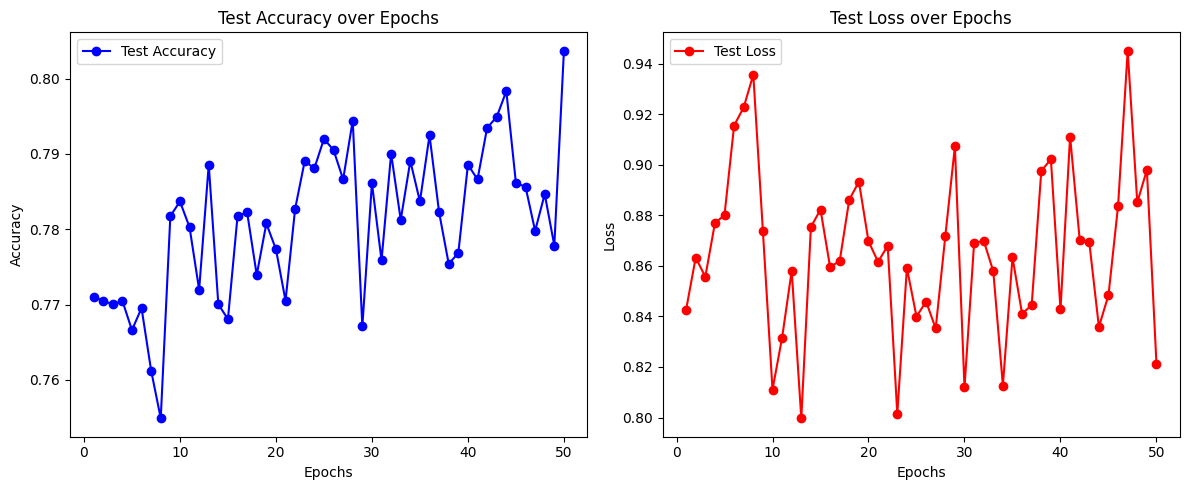

In [ ]:
import matplotlib.pyplot as plt

# Plot test accuracy and loss
epochs = range(1, len(test_acc_history) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, test_acc_history, 'bo-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_loss_history, 'ro-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# YOLOv5

## Classification

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -U -r yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
  Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_images_batch(image_paths, labels, img_height, img_width, batch_size=32):
    num_images = len(image_paths)
    images = []
    labels_batch = []

    for i in range(0, num_images, batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        batch_images = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            batch_images.append(img_array)

        batch_images = np.array(batch_images, dtype=np.float32)
        images.append(batch_images)
        labels_batch.append(np.array(batch_labels, dtype=np.float32))

    return np.concatenate(images), np.concatenate(labels_batch)

In [ ]:
# Extract features from YOLOv5 for the preprocessed images
X_train_batch, y_train_batch = preprocess_images_batch(X_train, y_train, 320, 320, batch_size=32)
X_val_batch, y_val_batch = preprocess_images_batch(X_val, y_val, 320, 320, batch_size=32)
X_test_batch, y_test_batch = preprocess_images_batch(X_test, y_test, 320, 320, batch_size=32)

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.image

base_path = "/content/drive/MyDrive/Colab Notebooks/ML Task 4/data"

# Create dataset tree
for split in ['train', 'val', 'test']:
    for class_id in range(102):  # Creating folders for 102 classes
        class_path = os.path.join(base_path, split, str(class_id))
        os.makedirs(class_path, exist_ok=True)

# Function to save images
def save_images(images, labels, split):
    for i, (img, label) in enumerate(zip(images, labels)):
        class_folder = os.path.join(base_path, split, str(int(label - 1)))
        img_path = os.path.join(class_folder, f"img_{i}.jpg")

        matplotlib.image.imsave(img_path, img)


# Save images in respective folders
save_images(X_train_batch, y_train_batch, "train")
save_images(X_val_batch, y_val_batch, "val")
save_images(X_test_batch, y_test_batch, "test")

print("Dataset tree created and images saved successfully!")


Dataset tree created and images saved successfully!


Train with dir of train and val without test

In [5]:
!echo 3 | python yolov5/classify/train.py --model yolov5s-cls.pt --data '/content/drive/MyDrive/Colab Notebooks/ML Task 4/data/' --epochs 20 --img 320

wandb: WARNING ‚ö†Ô∏è wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-02 17:57:57.842732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738519077.866446    6587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738519077.873374    6587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
classify/train: model=yolov5s-cls.pt, data=/content/drive/MyDrive/Colab Notebooks/ML Task 4/data/, epochs=20, batch_size=64, imgsz=320, nosave=False, cache=None, device=, workers=8, project=yolov5/runs/train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, 

In [9]:
import shutil

import os

files = os.listdir("yolov5/runs/train-cls/exp2/")  # Replace with your directory path
print(files)

for file in files:
  try:
    shutil.copy("yolov5/runs/train-cls/exp2/" + file, "/content/drive/MyDrive/Colab Notebooks/ML Task 4/final_reasults/")
  except:
    pass

['opt.yaml', 'results.csv', 'test_images.jpg', 'train_images.jpg', 'weights', 'events.out.tfevents.1738519080.d899e8ae190c.6587.0']


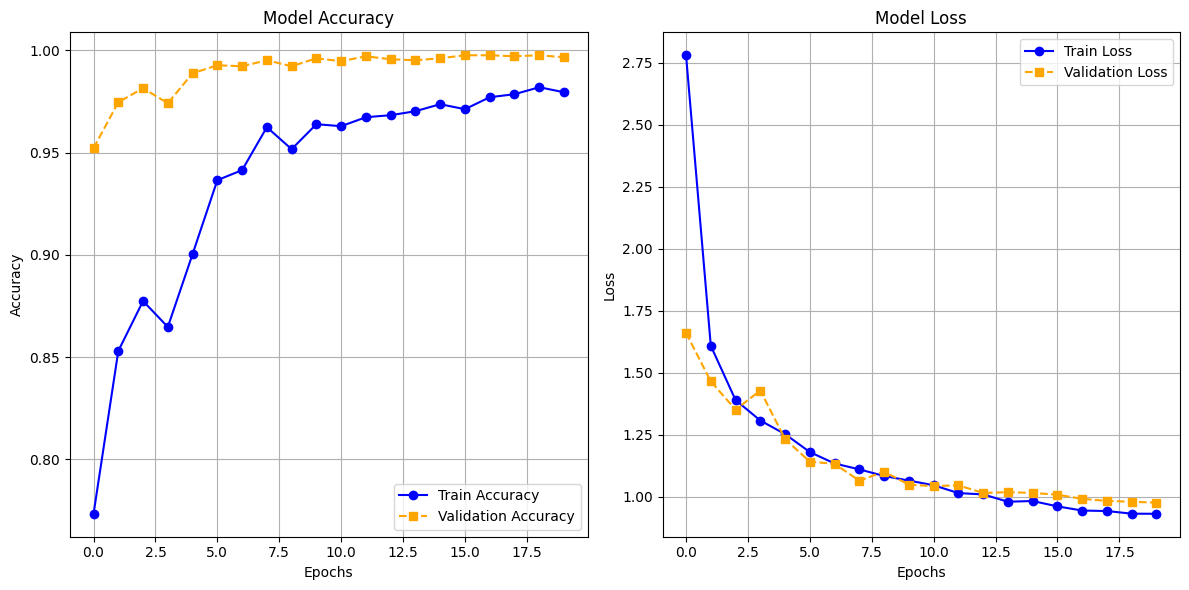

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/Colab Notebooks/ML Task 4/final_reasults/results.csv"
df = pd.read_csv(file_path)

df.columns = df.columns.str.strip()

# Extract data
epochs = df['epoch']
train_loss = df['train/loss']
val_loss = df['val/loss']
train_acc = df['metrics/accuracy_top1']  # Assuming this is train accuracy
val_acc = df['metrics/accuracy_top5']    # Assuming this is validation accuracy

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy Plot
ax1.plot(epochs, train_acc, label='Train Accuracy', color='blue', marker='o', linestyle='-')
ax1.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='s', linestyle='--')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss Plot
ax2.plot(epochs, train_loss, label='Train Loss', color='blue', marker='o', linestyle='-')
ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='s', linestyle='--')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


Validate val

In [26]:
!python yolov5/classify/val.py --weights yolov5/runs/train-cls/exp2/weights/best.pt --data '/content/drive/MyDrive/Colab Notebooks/ML Task 4/data' > classification_val_results.csv

classify/val: data=/content/drive/MyDrive/Colab Notebooks/ML Task 4/data, weights=['yolov5/runs/train-cls/exp2/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=yolov5/runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 üöÄ v7.0-398-g5cdad892 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
validating:   0% 0/16 [00:00<?, ?it/s]/content/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
validating: 100% 16/16 [00:04<00:00,  3.99it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2047       0.934       0.994
                       0          10           1           1
                       1          15       0.

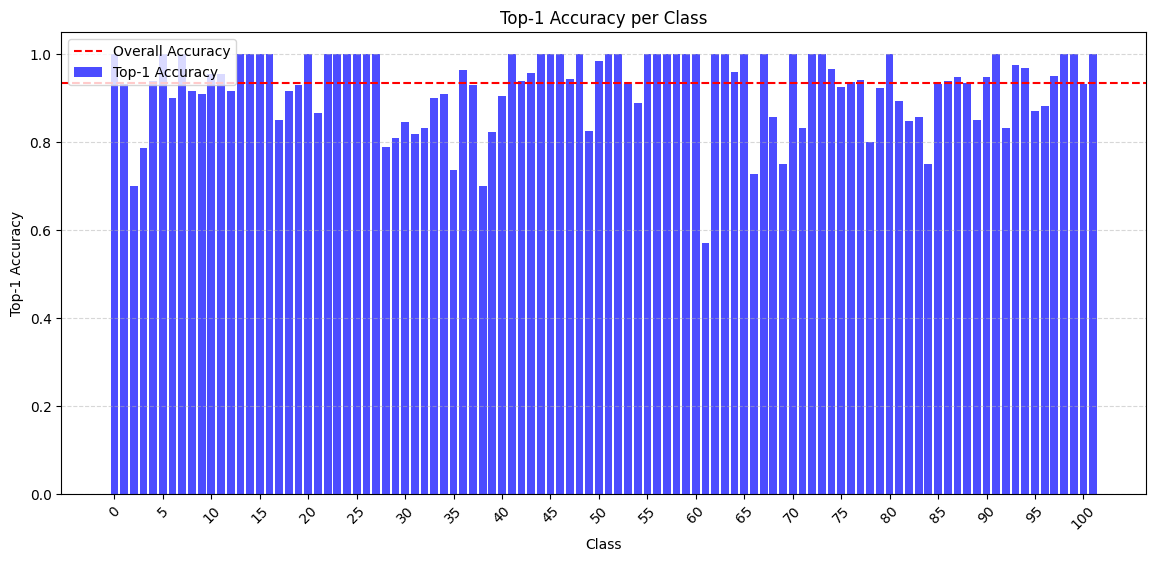

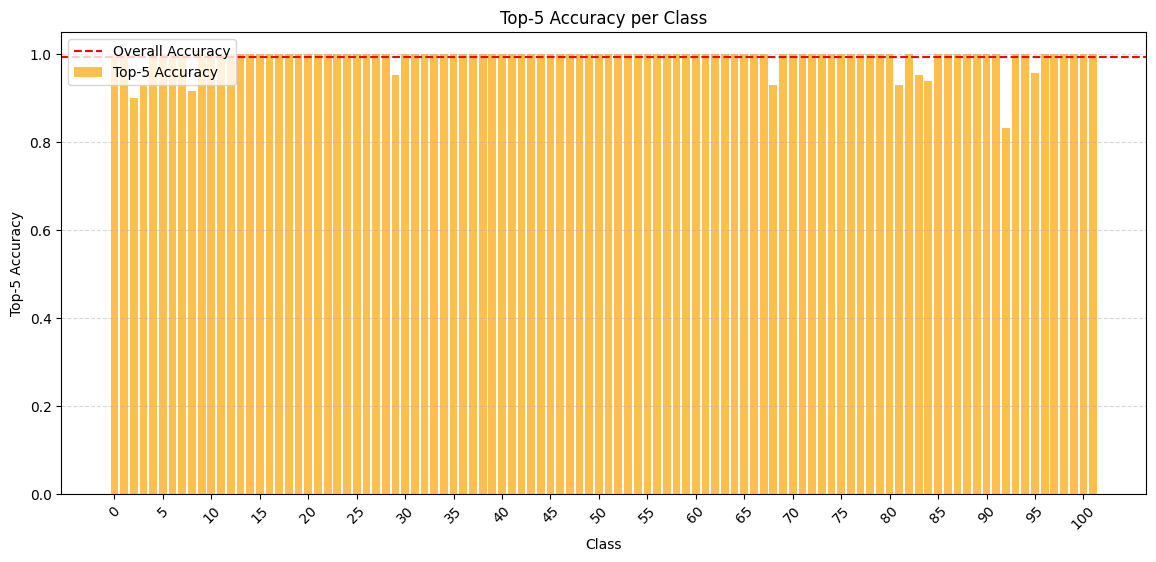

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

def show_test_accuracies(df):
    df_filtered = df[df['Class'] != 'all'].copy()
    df_filtered['Class'] = pd.to_numeric(df_filtered['Class'], errors='coerce')

    df_filtered = df_filtered.sort_values(by='Class', ignore_index=True)
    df_filtered['Class'] = df_filtered['Class'].astype(str)

    plt.figure(figsize=(14, 6))

    # Plot Top-1 Accuracy
    plt.bar(df_filtered['Class'], df_filtered['top1_acc'], color='blue', alpha=0.7, label="Top-1 Accuracy")
    plt.axhline(y=df[df['Class'] == 'all']['top1_acc'].values[0], color='r', linestyle='--', label="Overall Accuracy")

    plt.xlabel('Class')
    plt.ylabel('Top-1 Accuracy')
    plt.title('Top-1 Accuracy per Class')

    # Improve X-axis readability
    plt.xticks(rotation=45, fontsize=10)
    plt.xticks(range(0, len(df_filtered), max(1, len(df_filtered)//20)))  # Reduce number of ticks if too many

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    # Plot Top-5 Accuracy
    plt.figure(figsize=(14, 6))
    plt.bar(df_filtered['Class'], df_filtered['top5_acc'], color='orange', alpha=0.7, label="Top-5 Accuracy")
    plt.axhline(y=df[df['Class'] == 'all']['top5_acc'].values[0], color='r', linestyle='--', label="Overall Accuracy")

    plt.xlabel('Class')
    plt.ylabel('Top-5 Accuracy')
    plt.title('Top-5 Accuracy per Class')

    # Improve X-axis readability
    plt.xticks(rotation=45, fontsize=10)
    plt.xticks(range(0, len(df_filtered), max(1, len(df_filtered)//20)))  # Reduce number of ticks if too many

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Task 4/final_reasults/classification_val_results.csv")
show_test_accuracies(df)

Validate test

In [27]:
!python yolov5/classify/val.py --weights yolov5/runs/train-cls/exp2/weights/best.pt --data '/content/drive/MyDrive/Colab Notebooks/ML Task 4/data-test' > classification_test_results.csv

classify/val: data=/content/drive/MyDrive/Colab Notebooks/ML Task 4/data-test, weights=['yolov5/runs/train-cls/exp2/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=yolov5/runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 üöÄ v7.0-398-g5cdad892 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing:   0% 0/12 [00:00<?, ?it/s]/content/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
testing: 100% 12/12 [00:04<00:00,  2.96it/s]
                   Class      Images    top1_acc    top5_acc
                     all        1428       0.933       0.992
                       0           7           1           1
                       1          10         0

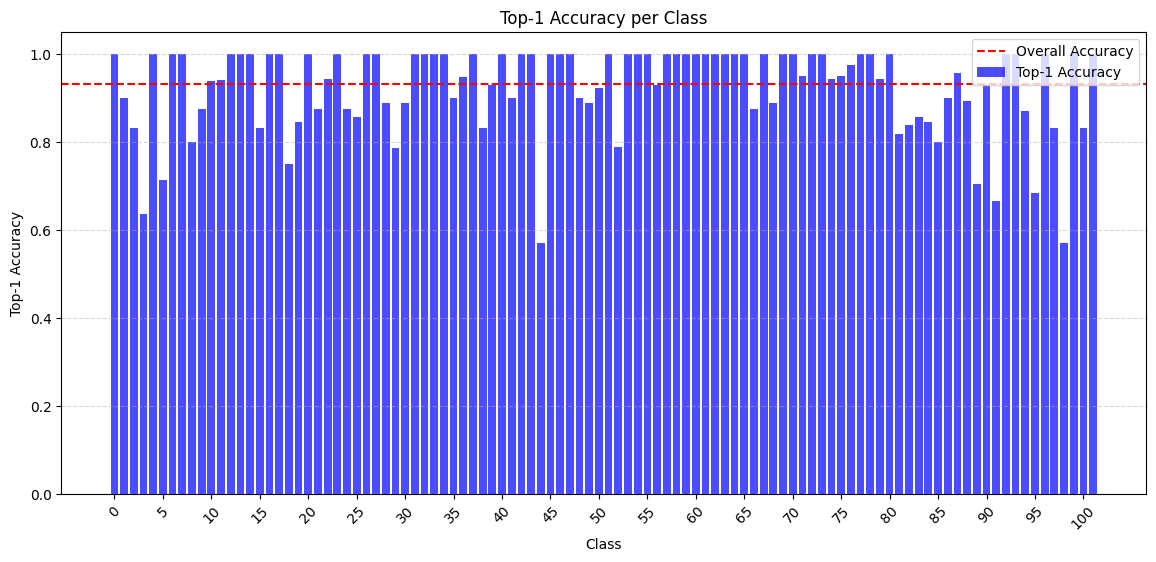

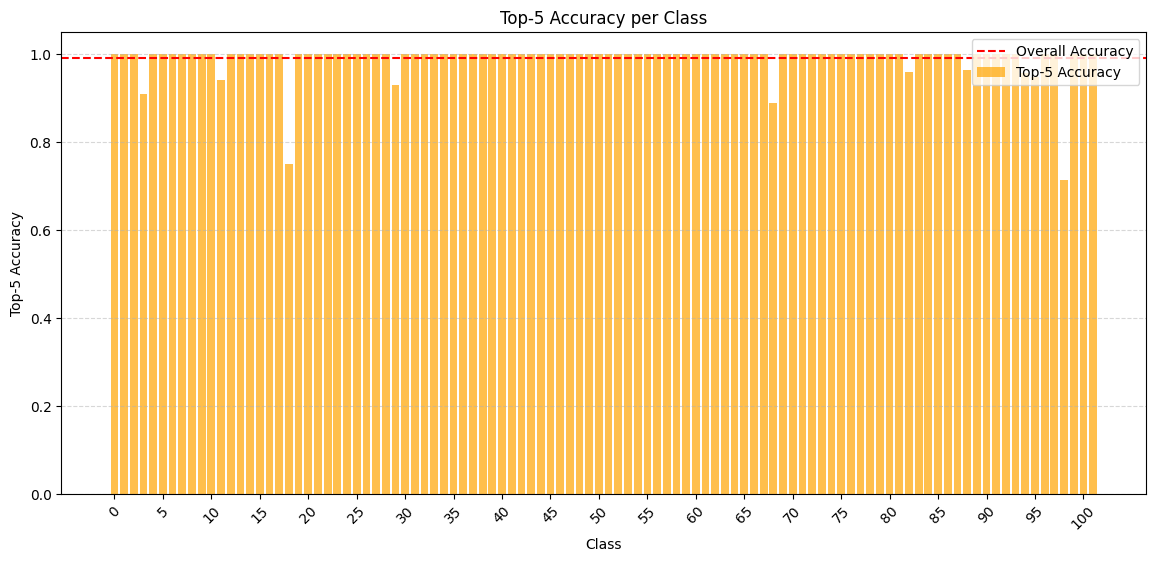

In [14]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Task 4/final_reasults/classification_test_results.csv")
show_test_accuracies(df)

In [ ]:
!python yolov5/classify/predict.py --weights yolov5/runs/train-cls/exp2/weights/best.pt --source '/content/drive/MyDrive/Colab Notebooks/ML Task 4/data-test/*/*' > classification_test_results.csv

## Detection

In [ ]:
from PIL import Image

import scipy.misc
import matplotlib.image

def copy(imgs, labels, role):
  for i in range(len(imgs)):
    image_path = "/content/drive/MyDrive/Colab Notebooks/ML Task 4/data/images/" + role + '/' + str(i) + ".jpg"
    label_path = "/content/drive/MyDrive/Colab Notebooks/ML Task 4/data/labels/" + role + '/' + str(i) + ".txt"

    matplotlib.image.imsave(image_path, imgs[i])

    with open(label_path, 'w') as label_file:
      label_file.write(str(labels[i] - 1) + " 0.5 0.5 1.0 1.0")

copy(X_train_batch, y_train_batch, 'train')
copy(X_val_batch, y_val_batch, 'val')
copy(X_test_batch, y_test_batch, 'test')

<ipython-input-23-4162325fbb2d>:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


In [ ]:
data_yaml = """
# Dataset paths relative to the yolov5 folder
train: /content/drive/MyDrive/Colab Notebooks/ML Task 4/data/images/train
val:   /content/drive/MyDrive/Colab Notebooks/ML Task 4/data/images/val
test:  /content/drive/MyDrive/Colab Notebooks/ML Task 4/data/images/test

# Number of classes
nc: 102

# Class names 0 - cat, 1 - dog
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101']
"""

with open("data.yaml", 'w') as data:
  data.write(data_yaml)

In [ ]:
!echo 3 | python yolov5/train.py --data data.yaml --weights yolov5x.pt --epochs 10 --batch 32 --freeze 10

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ‚ö†Ô∏è wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-31 14:06:13.918118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738332373.939066    5043 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738332373.945347    5043 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuB

In [ ]:
!python yolov5/val.py --data data.yaml --weights yolov5/runs/train/exp/weights/best.pt

val: data=data.yaml, weights=['yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 üöÄ v7.0-398-g5cdad892 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 322 layers, 86853043 parameters, 0 gradients, 205.9 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/ML Task 4/data/labels/val.cache... 2047 images, 0 backgrounds, 0 corrupt: 100% 2047/2047 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 64/64 [02:22<00:00,  2.22s/it]
                   all       2047       2047      0.693      0.408      0.486       0.44
Speed: 0.2ms pre-process, 63.5ms inference, 1.0ms NMS per image at shape (32,

In [ ]:
!python yolov5/val.py --data data.yaml --weights yolov5/runs/train/exp/weights/last.pt

val: data=data.yaml, weights=['yolov5/runs/train/exp/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 üöÄ v7.0-398-g5cdad892 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 322 layers, 86853043 parameters, 0 gradients, 205.9 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/ML Task 4/data/labels/val.cache... 2047 images, 0 backgrounds, 0 corrupt: 100% 2047/2047 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 64/64 [02:23<00:00,  2.25s/it]
                   all       2047       2047      0.693      0.408      0.486       0.44
Speed: 0.2ms pre-process, 64.1ms inference, 1.0ms NMS per image at shape (32,

In [ ]:
!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --source path/to/test/images --save-txt --save-conf